In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<function matplotlib.pyplot.show(close=None, block=None)>

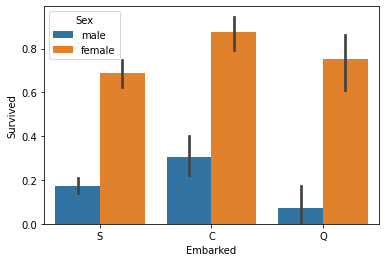

In [6]:
sns.barplot(x="Embarked",y="Survived",hue="Sex",data=train_data)
plt.show

In [8]:
#To avoid overfitting, I’m going to group people into logical human age groups.
def simplify_ages(df):
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
    categories = pd.cut(df.Age, bins, labels=group_names)
    df.Age = categories
    return df

#Each booth begins with a letter. I bet this letter is much larger than the number that follows, let’s cut it off.
def simplify_cabins(df):
    df.Cabin = df.Cabin.fillna('N')
    df.Cabin = df.Cabin.apply(lambda x: x[0])
    return df

#The tariff is another continuous value that should be simplified.
def simplify_fares(df):
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    group_names = ['Unknown', '1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return df

#Extract the information from the “Name” function. Rather than using the full name, I extracted the last name and name prefix (Mr, Mrs etc.) and then added them as characteristics.
def format_name(df):
    df['Lname'] = df.Name.apply(lambda x: x.split(' ')[0])
    df['NamePrefix'] = df.Name.apply(lambda x: x.split(' ')[1])
    return df    
    
#Finally, we need to remove unnecessary features.
def drop_features(df):
    return df.drop(['Ticket', 'Name', 'Embarked'], axis=1)

def transform_features(df):
    df = simplify_ages(df)
    df = simplify_cabins(df)
    df = simplify_fares(df)
    df = format_name(df)
    df = drop_features(df)
    return df

data_train = transform_features(train_data)
data_test = transform_features(test_data)

In [10]:
data_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Lname,NamePrefix
0,1,0,3,male,Student,1,0,1_quartile,N,"Braund,",Mr.
1,2,1,1,female,Adult,1,0,4_quartile,C,"Cumings,",Mrs.
2,3,1,3,female,Young Adult,0,0,1_quartile,N,"Heikkinen,",Miss.
3,4,1,1,female,Young Adult,1,0,4_quartile,C,"Futrelle,",Mrs.
4,5,0,3,male,Young Adult,0,0,2_quartile,N,"Allen,",Mr.


Encoding Features:
The next step is to standardize the labels. The Label encoder converts each unique string into a number, making the data more flexible that can be used for various algorithms. The result is a scary array of numbers for humans, but beautiful for machines:

In [11]:
!pip install sklearn

In [16]:
from sklearn import preprocessing
def encode_feature(df_train,df_test):
    features=['Fare','Cabin','Age','Sex','Lname','NamePrefix']
    df_combined=pd.concat([df_train[features],df_test[features]])
    
    for feature in features:
        le=preprocessing.LabelEncoder()
        le=le.fit(df_combined[feature])
        df_train[feature]=le.transform(df_train[feature])
        df_test[feature]=le.transform(df_test[feature])
    return df_train,df_test
data_train,data_test=encode_feature(data_train,data_test)

Now the next step is to divide the data into training and testing sets. Here I’ll be using one variable to store all the features minus the value we want to predict, and the other variable to store only the value we want to predict.

For this task, I’m going to randomly mix this data into four variables. In this case, I train 80% of the data, then I test the remaining 20%:

In [38]:
from sklearn.model_selection import train_test_split

X_all = data_train.drop(['Survived', 'PassengerId'], axis=1)
y_all = data_train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

Fitting and Tuning Machine Learning Algorithm:
Now is the time to determine which algorithm will provide the best model. In this task, I am going with the RandomForestClassifier, but you can also use any other classifier here, such as Support Vector Machines or Naive Bayes:

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer,accuracy_score
from sklearn.model_selection import GridSearchCV

In [21]:
#choose the type of classifier
clf=RandomForestClassifier()

In [26]:
#choose some parameter combination to try
parameters={'n_estimators':[4,6,9],
            'max_features':['log2','sqrt','auto'],
            'criterion':['entropy','gini'],
            'max_depth':[2,3,5,10],
            'min_samples_split':[2,3,5],
            'min_samples_leaf':[1,5,8]
           }

In [27]:
#Type of scoring used to compare parameter combination
acc_scorer=make_scorer(accuracy_score)

In [28]:
#Run the grid search
grid_obj=GridSearchCV(clf,parameters,scoring=acc_scorer)
grid_obj=grid_obj.fit(X_train,y_train)

In [29]:
#set the clf to the best combination of parameters
clf=grid_obj.best_estimator_

In [30]:
#Fit the best algorithm to the data
clf.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='sqrt',
                       min_samples_split=3, n_estimators=6)

In [31]:
predictions = clf.predict(X_test)
print(accuracy_score(y_test, predictions))

0.8212290502793296


Now we need to use KFold cross-validation to validate our machine learning model. KFold cross-validation helps to understand that is our model good? This makes it possible to verify the efficiency of the algorithm using KFold. This will divide our data into 10 compartments, then run the algorithm using a different compartment as the test set for each iteration:

In [39]:
from sklearn.model_selection import KFold

def run_kfold(clf):
    kf = KFold(n_splits=10)
    #kf.get_n_splits(891)
    outcomes = []
    fold = 0
    for train_index, test_index in kf.split(X_all):
        fold += 1
        X_train, X_test = X_all.values[train_index], X_all.values[test_index]
        y_train, y_test = y_all.values[train_index], y_all.values[test_index]
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        outcomes.append(accuracy)
        print("Fold {0} accuracy: {1}".format(fold, accuracy))     
    mean_outcome = np.mean(outcomes)
    print("Mean Accuracy: {0}".format(mean_outcome)) 

run_kfold(clf)

Fold 1 accuracy: 0.8333333333333334
Fold 2 accuracy: 0.8314606741573034
Fold 3 accuracy: 0.8089887640449438
Fold 4 accuracy: 0.8426966292134831
Fold 5 accuracy: 0.8314606741573034
Fold 6 accuracy: 0.8089887640449438
Fold 7 accuracy: 0.7752808988764045
Fold 8 accuracy: 0.797752808988764
Fold 9 accuracy: 0.8876404494382022
Fold 10 accuracy: 0.8202247191011236
Mean Accuracy: 0.8237827715355805


Testing the Model:
Now we need to predict on the actual test data:

In [40]:
ids = data_test['PassengerId']
predictions = clf.predict(data_test.drop('PassengerId', axis=1))
output = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
